In [1]:
# This notebook contains notes about PA estimation for MPL-8.

In [55]:
import numpy as np 
import pandas as pd
from astropy.io import fits
from mangadap.util.bitmask import BitMask
import os
import matplotlib.pyplot as plt
from cap_display_pixels import display_pixels
from fit_kinematic_pa import fit_kinematic_pa
from skimage import morphology

In [25]:
def channel_dictionary(hdu, ext):
    channel_dict = {}
    for k, v in hdu[ext].header.items():
        if k[0] == 'C':
            try:
                i = int(k[1:])-1
            except ValueError:
                continue
            channel_dict[v] = i
    return channel_dict

In [5]:
drpall = fits.open('/Users/cd201/Data/MaNGA/MPL-8-DAP/find_maps/drpall-v2_5_3.fits')[1].data
gal = drpall[(((drpall.mngtarg1 != 0) | (drpall.mngtarg3 != 0)) & ((drpall.mngtarg3 & int(2)**int(19)+int(2)**int(20)) == 0) )]
sdssMaskbits = os.path.join(os.environ['IDLUTILS_DIR'], 'data', 'sdss', 'sdssMaskbits.par')
bm = BitMask.from_par_file(sdssMaskbits, 'MANGA_DRP3QUAL')
critical = bm.flagged(gal.drp3qual, flag='CRITICAL')
data_dir = '/Users/cd201/Data/MaNGA/MPL-8-DAP/VOR10-GAU-MILESHC/'

In [15]:
gal[~critical].shape

(6387,)

In [23]:
# Pulling rando galaxy and finding velcity fields.
gal_str = gal[~critical]['plateifu'][0]
# Note: gal.plateifu provides a raw string array and gal['plateifu'] provides a unicode array. Certain unicode characters cannot be converted to raw string.
# Finding base MAPS directory and pulling individual files. (SET UP ENVIRONMENT)
file_name = 'manga-'+gal_str+'-MAPS-VOR10-MILESHC-MILESHC.fits.gz'
file_path = os.path.join(data_dir, gal_str.split("-")[0], gal_str.split("-")[1],file_name)

In [27]:
# Checking if file exists and then returning stellar/gas vfields.
if os.path.isfile(file_path) == False: 
    print(gal_str+' missing')
else:
    hdu = fits.open(file_path)
    emlc = channel_dictionary(hdu, 'EMLINE_GVEL')
    grid = hdu['SPX_SKYCOO'].data
    smask_ext = hdu['STELLAR_VEL'].header['QUALDATA']
    stellar_vfield = np.ma.MaskedArray(hdu['STELLAR_VEL'].data, mask=hdu[smask_ext].data > 0)
    gmask_ext = hdu['EMLINE_GVEL'].header['QUALDATA']
    halpha_vfield = np.ma.MaskedArray(hdu['EMLINE_GVEL'].data[emlc['Ha-6564'],:,:], mask=hdu[gmask_ext].data[emlc['Ha-6564'],:,:] > 0)

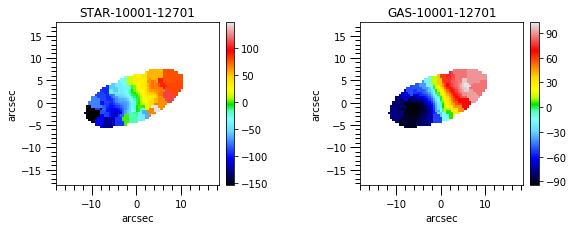

In [47]:
# init fig.
fig, ax = plt.subplots(1,2, figsize=(10,3))
# display_pixels doesn't like obj-orientated matplotlib
plt.sca(ax[0])
display_pixels(grid[0][~stellar_vfield.mask],grid[1][~stellar_vfield.mask],stellar_vfield[~stellar_vfield.mask],colorbar=True)
ax[0].set_title('STAR-'+str(gal_str))

plt.sca(ax[1])
display_pixels(grid[0][~halpha_vfield.mask],grid[1][~halpha_vfield.mask],halpha_vfield[~halpha_vfield.mask],colorbar=True)
ax[1].set_title('GAS-'+str(gal_str))

ax[0].set_xlim([np.min(grid[0]), np.max(grid[0])])
ax[0].set_ylim([np.min(grid[1]), np.max(grid[1])])
ax[1].set_xlim([np.min(grid[0]), np.max(grid[0])])
ax[1].set_ylim([np.min(grid[1]), np.max(grid[1])])
ax[0].set_xlabel('arcsec')
ax[0].set_ylabel('arcsec')
ax[1].set_xlabel('arcsec')
ax[1].set_ylabel('arcsec')
plt.show()

In [50]:
# Given a path to maps file this returns the stellar and halpha velocity fields and coordinates.
# X (Y) coordinates accessed by grid[0] (1).

def load_vfields(file_path):
    # Checking if file exists and then returning stellar/gas vfields.
    if os.path.isfile(file_path) == False: 
        print(gal_str+' missing')
        return np.nan, np.nan, np.nan 

    hdu = fits.open(file_path)
    emlc = channel_dictionary(hdu, 'EMLINE_GVEL')
    grid = hdu['SPX_SKYCOO'].data
    smask_ext = hdu['STELLAR_VEL'].header['QUALDATA']
    stellar_vfield = np.ma.MaskedArray(hdu['STELLAR_VEL'].data, mask=hdu[smask_ext].data > 0)
    gmask_ext = hdu['EMLINE_GVEL'].header['QUALDATA']
    halpha_vfield = np.ma.MaskedArray(hdu['EMLINE_GVEL'].data[emlc['Ha-6564'],:,:], mask=hdu[gmask_ext].data[emlc['Ha-6564'],:,:] > 0) 
    return grid, stellar_vfield, halpha_vfield
    

In [51]:
grid, stellar_vfield, halpha_vfield = load_vfields(file_path)

In [70]:
def reg_remove(vfield, thres=0.1):
    # Only mask required for region size identifier.
    # Selecting total number of pixels with observation, NOT, the total area.
    ms = thres * np.sum(~vfield.mask.flatten())
    reg_filter = morphology.remove_small_objects(~vfield.mask, min_size = ms)
    return reg_filter

In [96]:
stel_reg = reg_remove(stellar_vfield)

/Users/cd201/anaconda3/lib/python3.6/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


In [101]:
# Testing library of functions from pa_funcs.

In [106]:
import pa_funcs
import imp

In [175]:
imp.reload(pa_funcs)

<module 'pa_funcs' from '/Users/cd201/mpl8-kin-mis/scripts/pa_funcs.py'>

/Users/cd201/anaconda3/lib/python3.6/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "
/Users/cd201/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:664: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


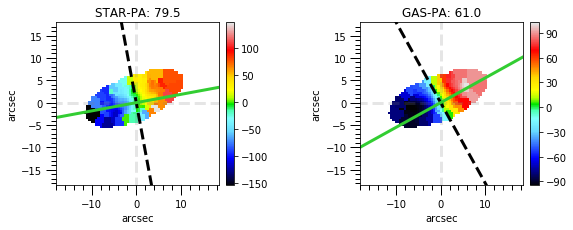

In [176]:
plt.close()
saxis, gaxis = pa_funcs.pa_wrapper(file_path)
plt.show()